# Prompt

### Assume we have two continuous data streams :
- Stream A
    - schema : { unique_identifier, number, text }
    - velocity : 100k records per day
    - cardinality : bounded at around 3M ( so, in 30 days we update all records )
- Stream B
    - schema : { unique_identifier, Stream_A_unique_identifier, number, text }
        - these are essentially child objects of Stream A
    - velocity : 1M records per day
    - cardinality : unbounded ~ although, of the 1M / day, 80% are overlapping
    
### Requirements
- support realtime, or near-realtime event notifications ( looking for some signal in the text )
- support rolling aggregates over a period of time
    - number of Schema B items in the past N hours
    - number of Schema B w/ condition in past N hours
- support lookup of Stream A assets by by identifier
- support lookup of Stream B assets by Stream_A identifiers
- support analytics projects for Stream A/B ( ie : custom analytics for "data-science" explorations that don't bring down the system )

## Initial Def

### Functional Components
- Ingestion Layer - ingests data streams from external sources
- Real-Time Processing Layer - signal event notifications
- Storage Layer - document storage due to semi-struc nature of data
- Async Analytics Layer - queryable interface to suport lookup/aggregations/analytics

In [10]:
from diagrams import Cluster, Diagram
from diagrams.aws.analytics import KinesisDataAnalytics, KinesisDataStreams, KinesisDataFirehose
from diagrams.aws.database import Dynamodb
from diagrams.aws.compute import LambdaFunction
from diagrams.saas.chat import Slack
from diagrams.generic.compute import Rack

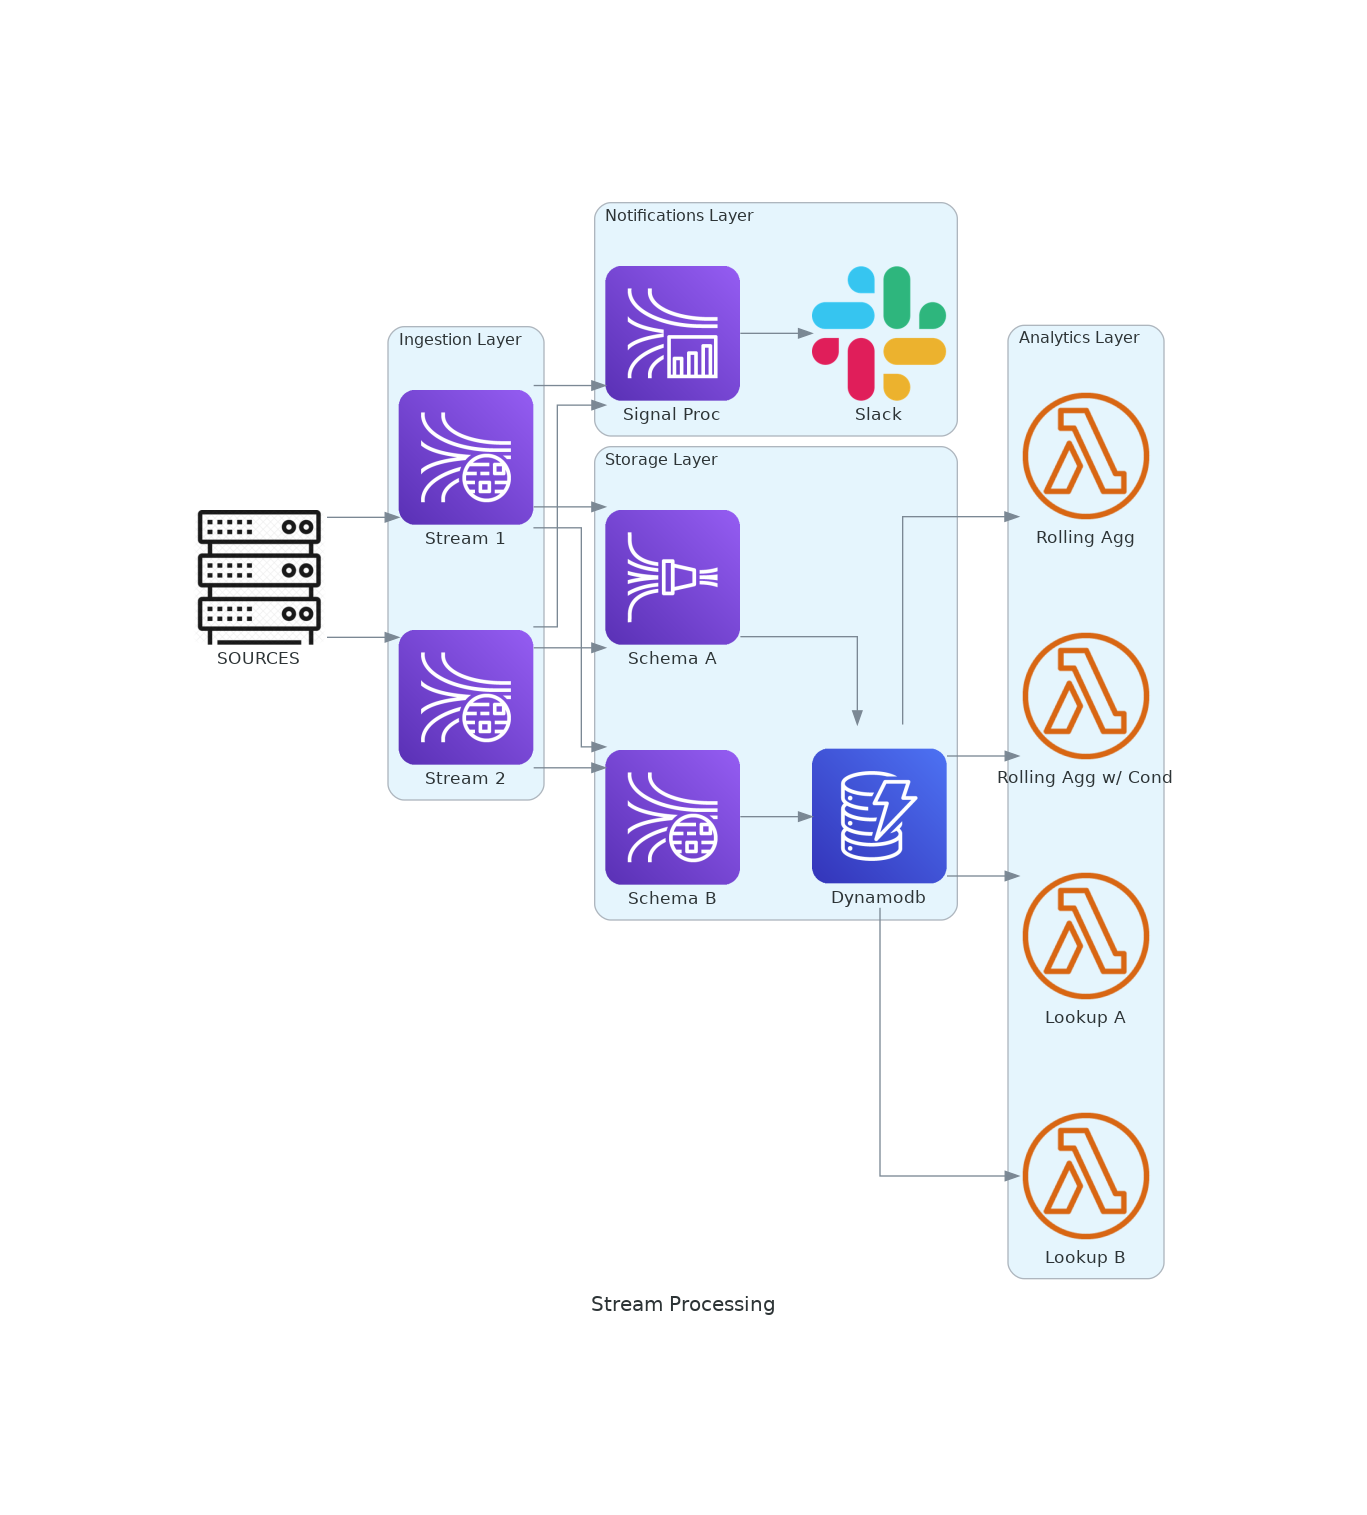

In [23]:
with Diagram("Stream Processing", show=False) as diag:
    source = Rack("SOURCES")
    
    with Cluster("Ingestion Layer"):
        stream_group = [
            KinesisDataStreams("Stream 1"),
            KinesisDataStreams("Stream 2")
        ]
        
    with Cluster("Notifications Layer"):
        rtp = KinesisDataAnalytics("Signal Proc")
        slack = Slack("Slack")
        
    with Cluster("Storage Layer"):
        schemaA = KinesisDataFirehose("Schema A")
        schemaB = KinesisDataStreams("Schema B")
        store = Dynamodb("Dynamodb")
        
    with Cluster("Analytics Layer"):
        aggregate1 = LambdaFunction("Rolling Agg")
        aggregate2 = LambdaFunction("Rolling Agg w/ Cond")
        lookup1 = LambdaFunction("Lookup A")
        lookup2 = LambdaFunction("Lookup B")
    
    
    source >> stream_group
    stream_group >> rtp >> slack
    stream_group >> schemaA >> store
    stream_group >> schemaB >> store
    store >> aggregate1
    store >> aggregate2
    store >> lookup1
    store >> lookup2
    
diag